Daniel Shackelford

CSPB 3202 Kaggle Competition

Histopathologic Cancer Detection

<img src="final_submission.JPG">

***Overall position 727***

1) Data:


The goal of this challenge is to solve a binary classification problem that comes in the form of classification of images to detect cancer. We are provided with a set of images of lymph node tissue that measures 96x96 pixels. We are trying to report if the center 32x32 pixels in a given image show signs of cancer. There are roughly 220,000 labeled training images given for this test and 57,000 test images. It is important to note that the image sets given are guaranteed to not contain any duplicate values. 

In [116]:
from glob import glob # recommended for finding filenames inside file struct

import pandas as pd
import numpy as np
import keras
import cv2 # cv2 used for image processing
import os


from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Conv2D, MaxPool2D

from tqdm import tqdm_notebook, notebook, tqdm, trange # recommended progress bar for running
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import gc 

In [117]:
# need to create a pandas dataframe containing the path of all files with the given lables

path = "E:/CSPB3022Kaggle/histopathologic-cancer-detection/" 
train_path = path + 'train/'
test_path = path + 'test/'

#initialize df and load the filenames in using glob
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) # load the filenames
print(df.head(5))

                                                path
0  E:/CSPB3022Kaggle/histopathologic-cancer-detec...
1  E:/CSPB3022Kaggle/histopathologic-cancer-detec...
2  E:/CSPB3022Kaggle/histopathologic-cancer-detec...
3  E:/CSPB3022Kaggle/histopathologic-cancer-detec...
4  E:/CSPB3022Kaggle/histopathologic-cancer-detec...


In [118]:
# print('???????????')
# E:/CSPB3022Kaggle/histopathologic-cancer-detection/train/........
df['id'] = df.path.map(lambda x: x.split('/')[3].split(".")[0][6:]).astype('str') # keep only the file names in 'id'

print(df.head(5))

labels = pd.read_csv(path+"train_labels.csv") # read the provided labels

df = df.merge(labels, on = "id") # merge labels and filepaths
df.head(5) # print the first three entrys

                                                path  \
0  E:/CSPB3022Kaggle/histopathologic-cancer-detec...   
1  E:/CSPB3022Kaggle/histopathologic-cancer-detec...   
2  E:/CSPB3022Kaggle/histopathologic-cancer-detec...   
3  E:/CSPB3022Kaggle/histopathologic-cancer-detec...   
4  E:/CSPB3022Kaggle/histopathologic-cancer-detec...   

                                         id  
0  00001b2b5609af42ab0ab276dd4cd41c3e7745b5  
1  000020de2aa6193f4c160e398a8edea95b1da598  
2  00004aab08381d25d315384d646f5ce413ea24b1  
3  0000d563d5cfafc4e68acb7c9829258a298d9b6a  
4  0000da768d06b879e5754c43e2298ce48726f722  


,path,id,label
0,E:/CSPB3022Kaggle/histopathologic-cancer-detec...,00001b2b5609af42ab0ab276dd4cd41c3e7745b5,1
1,E:/CSPB3022Kaggle/histopathologic-cancer-detec...,000020de2aa6193f4c160e398a8edea95b1da598,0
2,E:/CSPB3022Kaggle/histopathologic-cancer-detec...,00004aab08381d25d315384d646f5ce413ea24b1,0
3,E:/CSPB3022Kaggle/histopathologic-cancer-detec...,0000d563d5cfafc4e68acb7c9829258a298d9b6a,0
4,E:/CSPB3022Kaggle/histopathologic-cancer-detec...,0000da768d06b879e5754c43e2298ce48726f722,1


In [119]:
#This function takes in a dataframe df and loads in the specified number of images N
def load_data(N,df):
    # allocate a numpy array for the images. Each image is 96x96 and we need all rgb values.
    X = np.zeros([N,96,96,3],dtype=np.uint8) 
    # print(X)
    # print('///////////////////////////////////////////////')
    # print(df.values)
    # need labels for the associated data
    y = np.squeeze(df['label'])[0:N]
    # read in each image. tdqm notebook displays a progress bar
    for i, row in tqdm_notebook(df.iterrows(), total=N):
        if i == N:
            break
        X[i] = cv2.imread(row['path'])
          
    return X,y

In [120]:
# Load 10,000 images
N=10000
X,y = load_data(N,df) 

C:\Users\Dshac\anaconda3\lib\site-packages\ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


2) EDA:

In order to decide which model we will be using to analyze our system, we must first get some knowledge of what our data looks like and if there are any major characteristics of it that we can exploit later in the model. We can begin by doing a quick random pull of images from the data set to see if there are any easily discernable differences between the positive and negative data sets. 

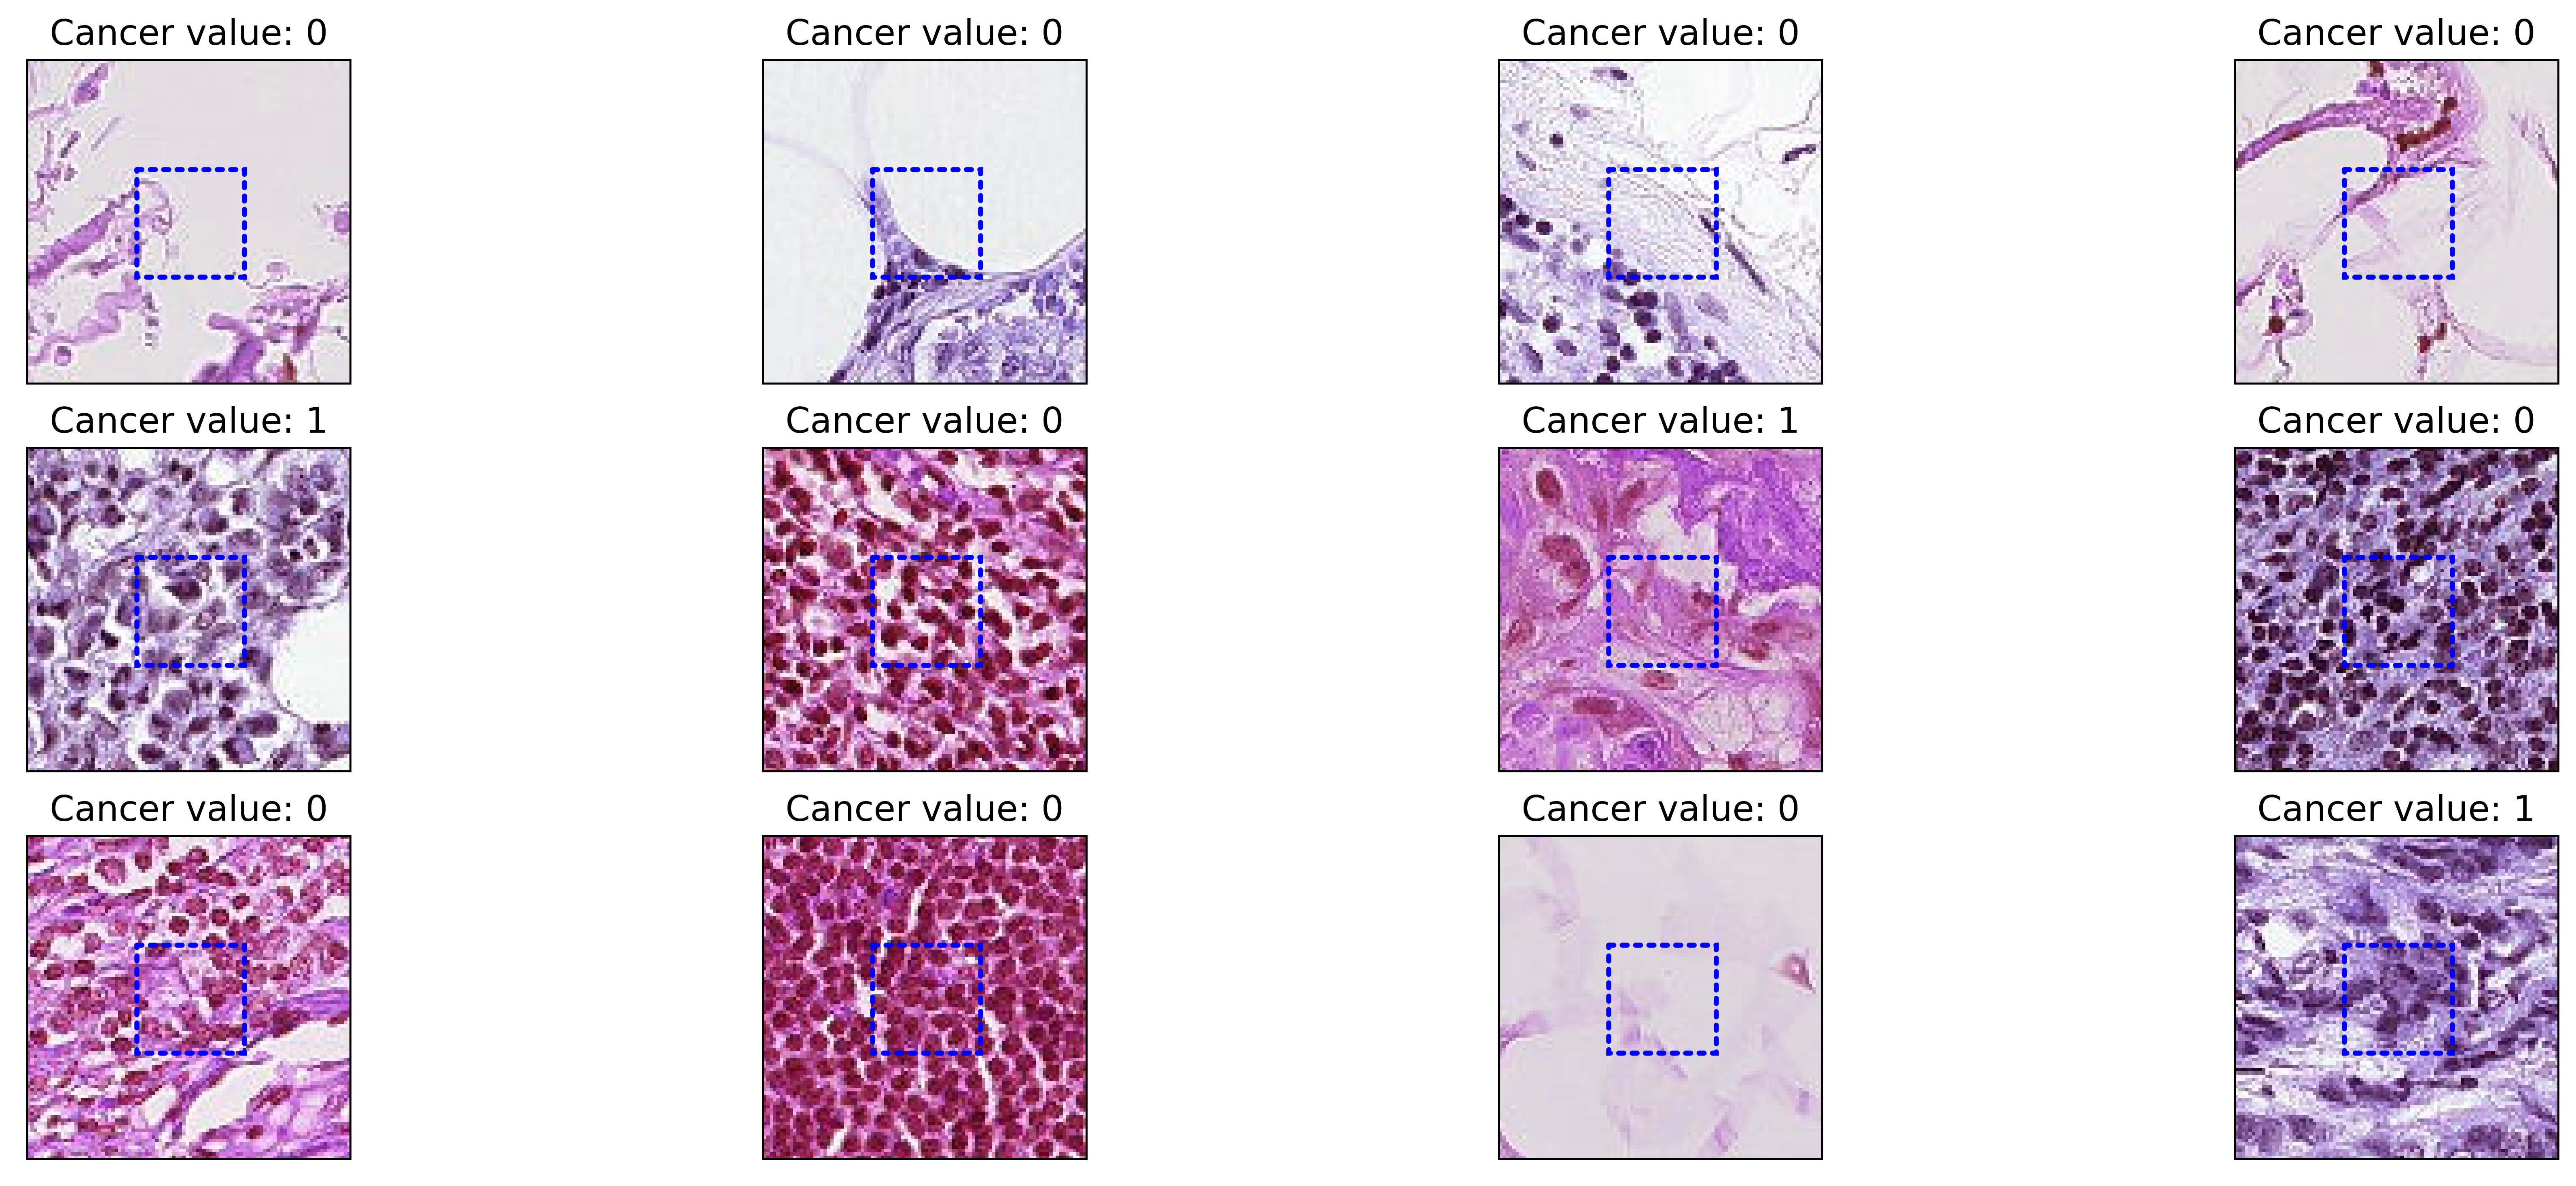

In [121]:
fig = plt.figure(figsize=(20, 8), dpi=450)
np.random.seed(101) 
for val,ind in enumerate(np.random.randint(0,N,12)):
    ax = fig.add_subplot(3, 12//3, val+1, xticks=[], yticks=[]) 
    plt.imshow(X[ind]) #plot image
    #patches allows me to add a box so we can see the patch of 32x32 that is of interest
    #idea taken from: https://www.kaggle.com/qitvision/a-complete-ml-pipeline-fast-ai
    box = patches.Rectangle((32,32),32,32,linewidth=2,edgecolor='b',facecolor='none', linestyle=':', capstyle='round')
    ax.add_patch(box) 
    ax.set_title('Cancer value: ' + str(y[ind]), fontsize=14) 

As can be seen from the images above, we cant tell with the human eye which cells correspond with cancer cells and which ones do not. We can look deeper into the data distributions by looking into how many images belong to each classification. 

Text(0, 0.5, 'Samples')

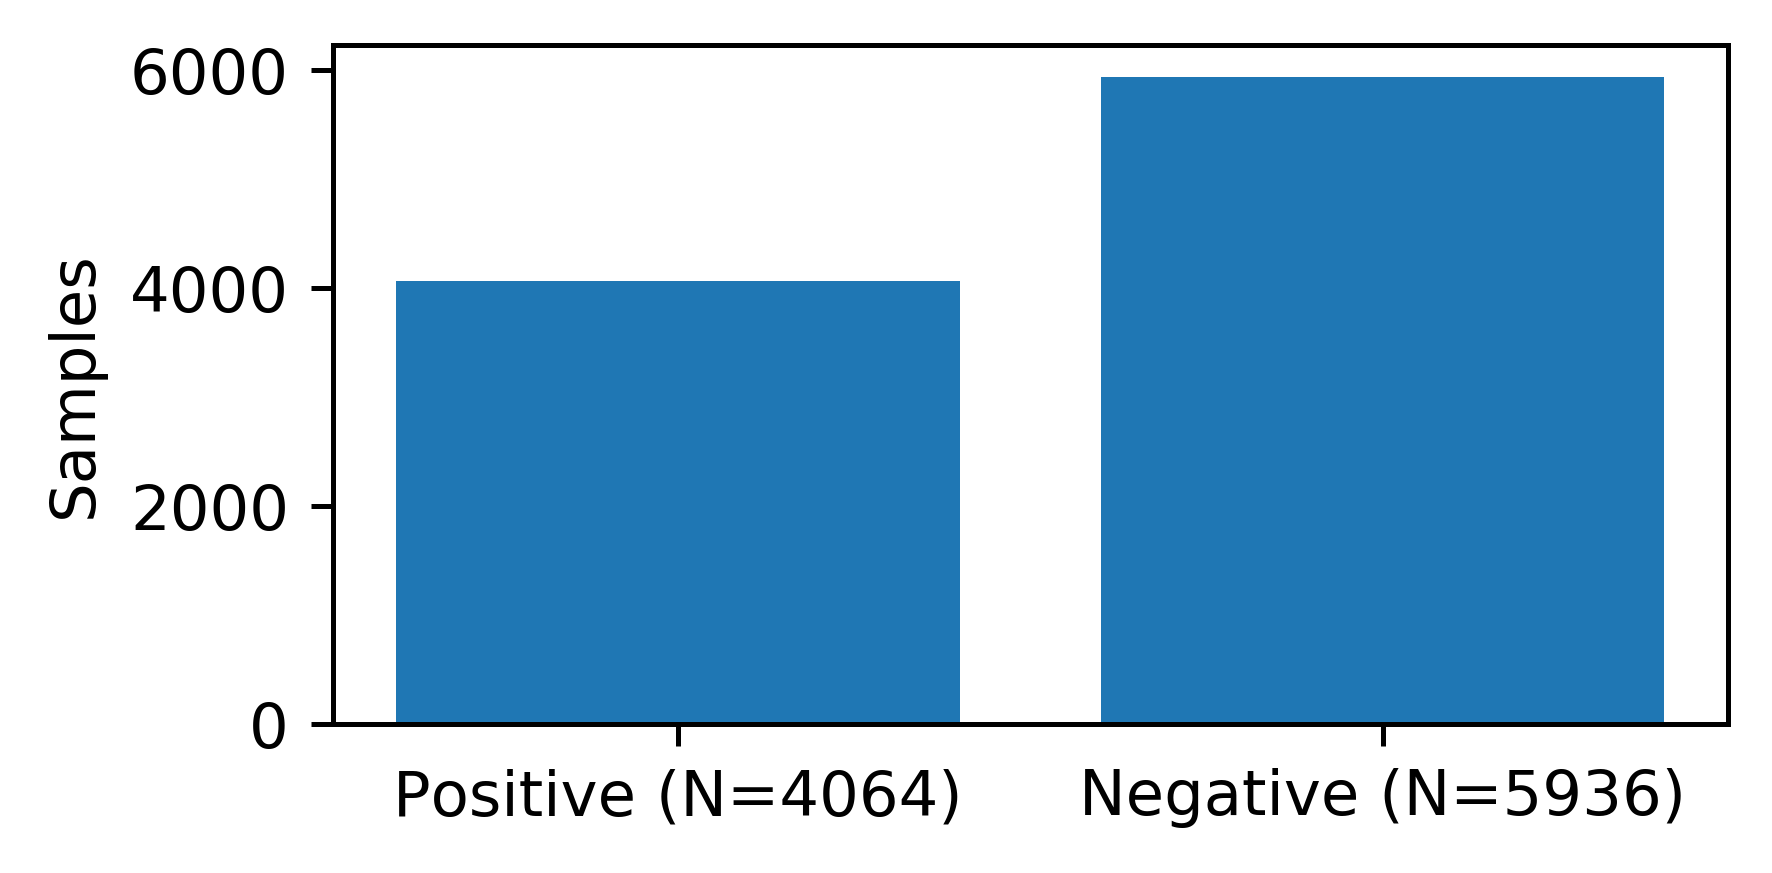

In [122]:
fig = plt.figure(figsize=(4, 2), dpi=450)

plt.bar([1,0], [(y==0).sum(), (y==1).sum()]); #plot a bar chart of the label frequency
plt.xticks([1,0],["Negative (N={})".format((y==0).sum()),"Positive (N={})".format((y==1).sum())]);
plt.ylabel("Samples")

The data shows that 40.64 percent of the given 10K images are positive, and the others are negative. In a binary classification problem, this becomes very important because a model that simply predicts negative on every run would be expected to get around a 60 percent accuracy. 

In [123]:
# split all training data into two sets. 
posSamples = X[y == 1]
negSamples = X[y == 0]

We can then analyze the distribution of RGB values across each of the values and combined for both the positive and negative data values. 

Text(0, 0.5, 'Relative frequency')

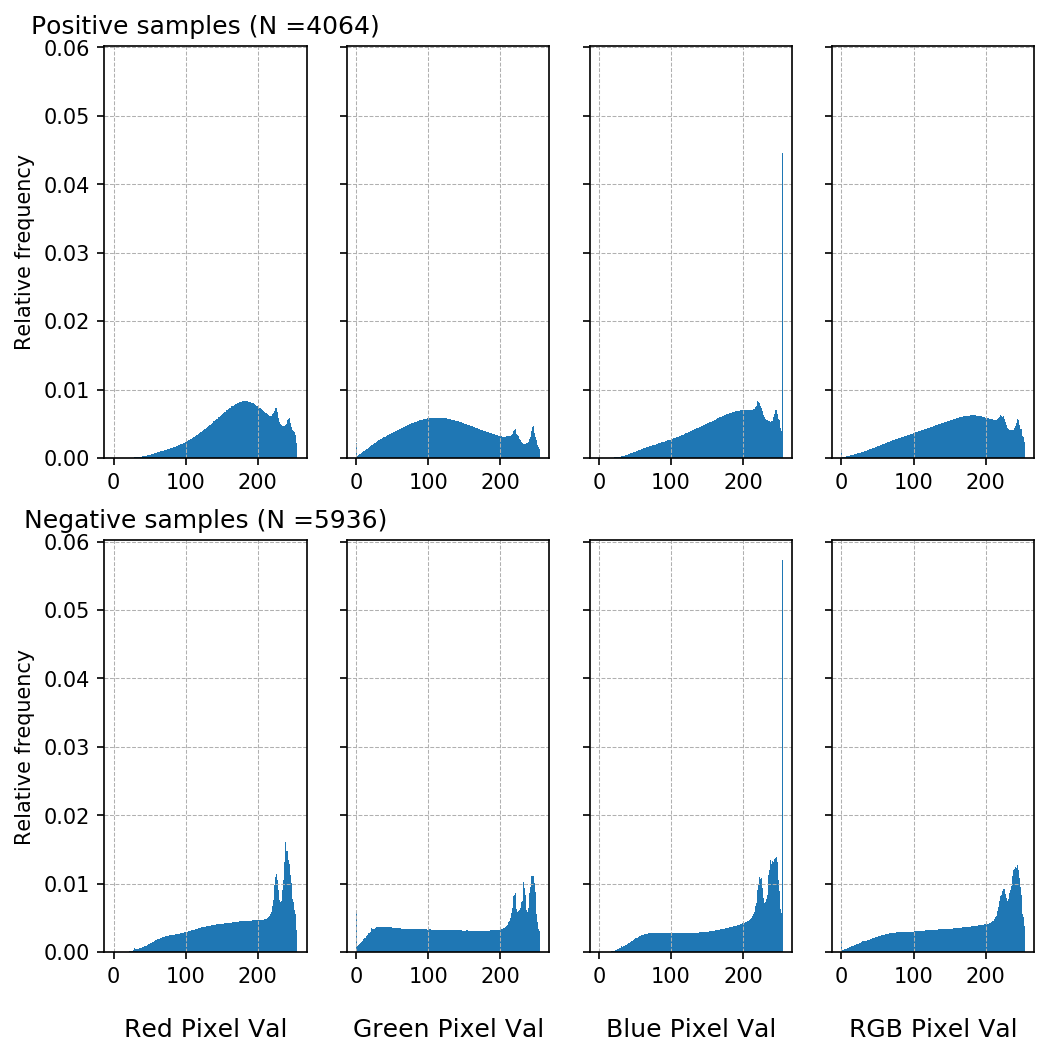

In [124]:
#analyze distributions of rgb values individually and together. 

numberOfBins = 256 #each possible pixel value will get a bin in the following histograms
fig,axs = plt.subplots(2,4,sharey=True,figsize=(8,8),dpi=150)

for i in range(4):
    axs[0,i].grid(linestyle = '--', linewidth = 0.5)
    axs[1,i].grid(linestyle = '--', linewidth = 0.5)

#RGB channels
axs[0,0].hist(posSamples[:,:,:,0].flatten(),bins=numberOfBins,density=True)
axs[1,0].hist(negSamples[:,:,:,0].flatten(),bins=numberOfBins,density=True)
axs[0,1].hist(posSamples[:,:,:,1].flatten(),bins=numberOfBins,density=True)
axs[1,1].hist(negSamples[:,:,:,1].flatten(),bins=numberOfBins,density=True)
axs[0,2].hist(posSamples[:,:,:,2].flatten(),bins=numberOfBins,density=True)
axs[1,2].hist(negSamples[:,:,:,2].flatten(),bins=numberOfBins,density=True)

#All channels
axs[0,3].hist(posSamples.flatten(),bins=numberOfBins,density=True)
axs[1,3].hist(negSamples.flatten(),bins=numberOfBins,density=True)

#Set image labels
axs[0,0].set_title("Positive samples (N =" + str(posSamples.shape[0]) + ")");
axs[1,0].set_title("Negative samples (N =" + str(negSamples.shape[0]) + ")");

axs[1,0].set_xlabel("Red Pixel Val",rotation='horizontal',labelpad=15,fontsize=12)
axs[1,1].set_xlabel("Green Pixel Val",rotation='horizontal',labelpad=15,fontsize=12)
axs[1,2].set_xlabel("Blue Pixel Val",rotation='horizontal',labelpad=15,fontsize=12)
axs[1,3].set_xlabel("RGB Pixel Val",rotation='horizontal',labelpad=15,fontsize=12)

axs[0,0].set_ylabel("Relative frequency")
axs[1,0].set_ylabel("Relative frequency")


This data shows a relatively clear trend. Negative samples seem to be higher values in general. There is also a much higher distribution of values of 255 in the negative set of data. This would denote that there is a higher frequency of negative samples that are white or near-white than postivie samples. We can then try a similar approach analyzing the mean of the entire brightness of an image as it relates to classification of image. 

Text(0.5, 0, 'Mean brightness')

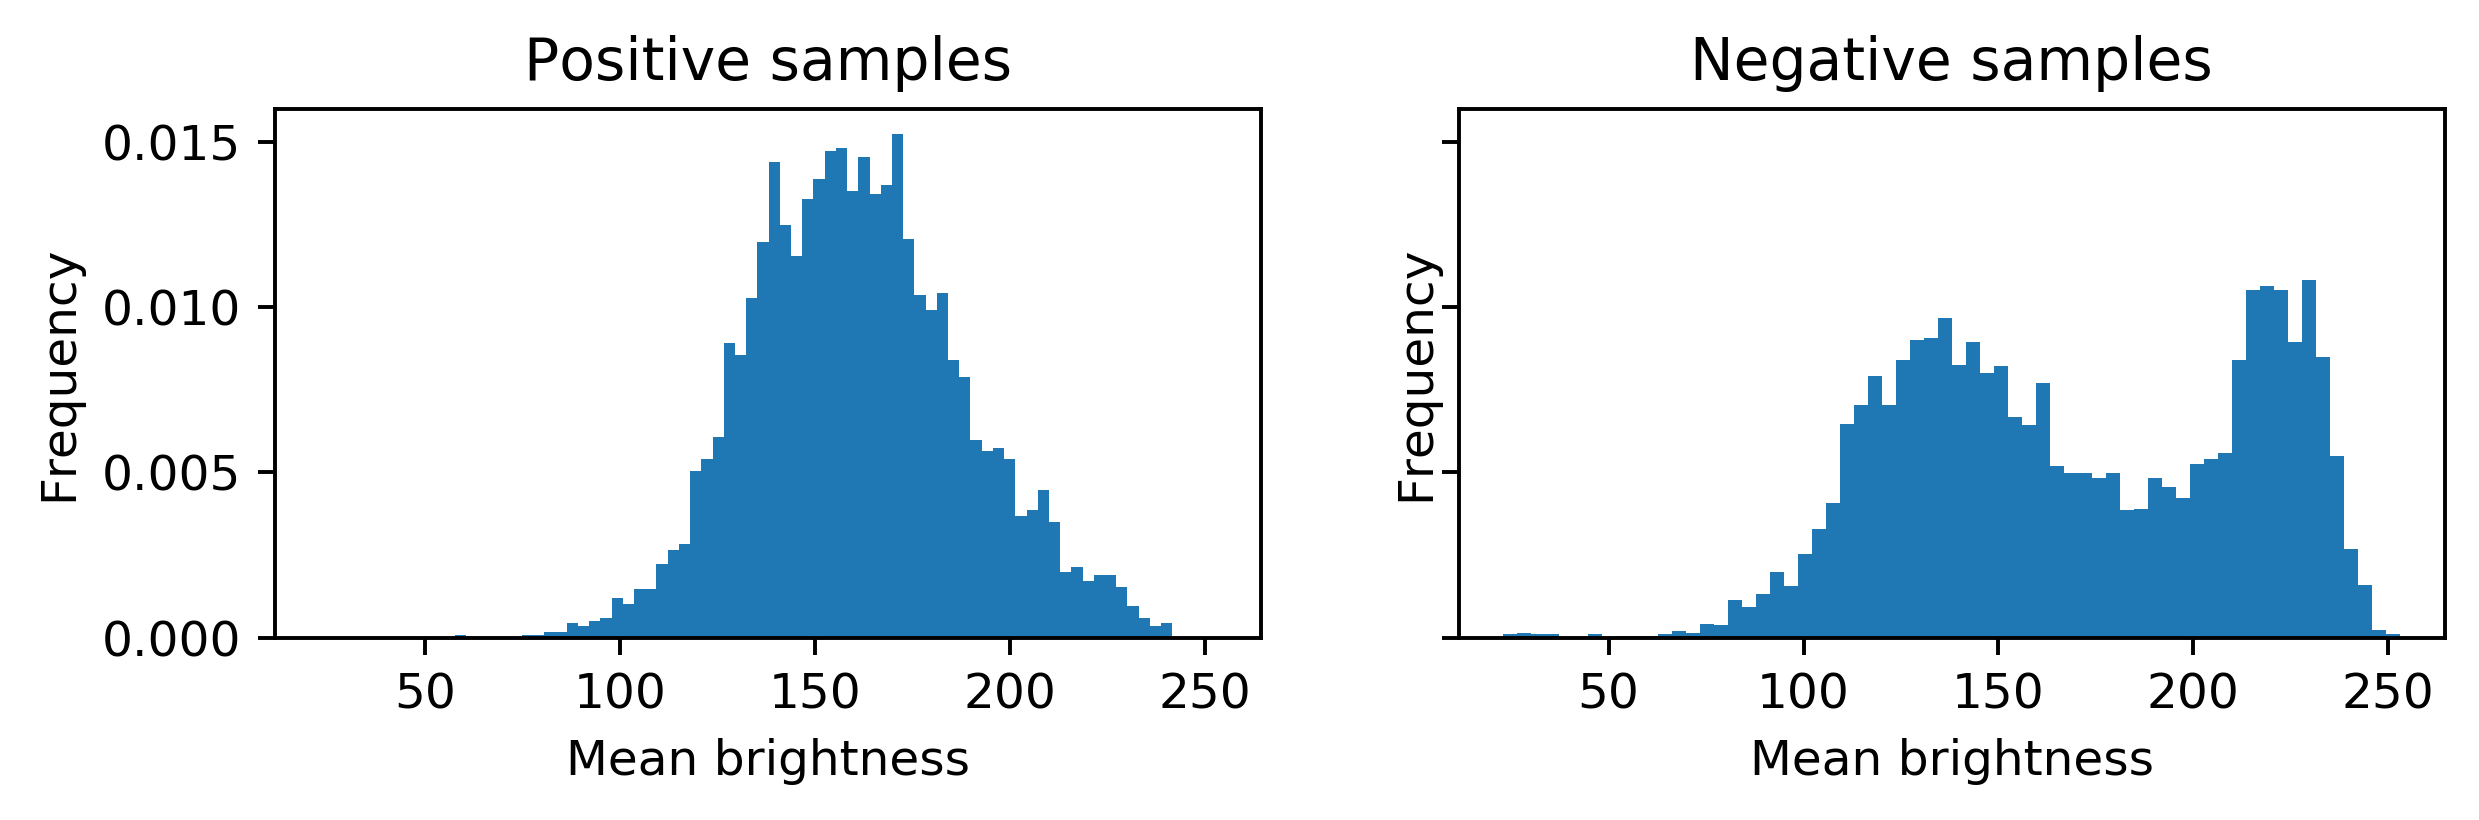

In [125]:
numberOfBins = 64 #we use a bit fewer bins to get a smoother image
fig,axs = plt.subplots(1,2,sharey=True, sharex = True, figsize=(8,2),dpi=350)
axs[0].hist(np.mean(posSamples,axis=(1,2,3)),bins=numberOfBins,density=True);
axs[1].hist(np.mean(negSamples,axis=(1,2,3)),bins=numberOfBins,density=True);
axs[0].set_title("Positive samples");
axs[1].set_title("Negative samples");
axs[0].set_ylabel("Frequency")
axs[1].set_ylabel("Frequency");
axs[0].set_xlabel("Mean brightness")
axs[1].set_xlabel("Mean brightness")


The comparison between the mean brightness of the positive samples and negative samples also shows some stark differences betweent the two sets. The most obvious is that in the negative samples there is a high centration around 140 and 230, and in the postiive samples there is a high concentration around 160. 


3) Model architecture and reasoning

Overall the data seen above is relatively well balanced and accesible. 

Now we can begin to work on a model for analysis. First we must load the data set. 

In [126]:
N = df["path"].size # get the number of images in the training data set
X,y = load_data(N,df)

C:\Users\Dshac\anaconda3\lib\site-packages\ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


We can split the training data into two sets, one for training and one for validation, which can be done in place. We will define the training set to be 80% of the data, and leave the remaining 20% of the data to be used for validation. We can also shuffle the data to ensure a completely random split. 

In [127]:
training_portion = 0.8 # Specify training/validation ratio
split_idx = int(np.round(training_portion * y.shape[0])) #Compute split idx

np.random.seed(111) #set the seed to ensure reproducibility

#shuffle
ind = np.arange(y.shape[0])
np.random.shuffle(ind)
X = X[ind]
y = y[ind]

We can then use Keras during the set up of our neural network architecture. We will set up a 'standard' convolutional neural network with three blocks of convolutional layers that utilize batch normalization, pooling, and dropout. Batch normalization is a technique used to automatically standardize inputs to a layer and helps to accelerate training. These layers will be added through the other layers in Keras. We utilize dropout for regularization with a probability of 0.3 for convolution layers and 0.5 for the last dense layer. Dropout is mainly used to prevent a model from overfitting a data set. In general, dropout is a technique where randomnly selected neurons in the network are ignored during the training. This temporarily removes them from the training set and weight updates are not passed to them, which in a sense makes the other neurons 'handle the load' from those being skipped. We then will initialize a sequential model for our analysis. Sequential models are appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor. 

Inside of the model for each of the layers, we will specify a 'relu' activation, which applies a rectified linear unit activation function. This function return the element-wise maximum of 0 and the input tensor. 

In the end layer, we will use the sigmoid function to predict a value between 0 and 1. We use the sigmoid function because its one of the best suited activation functions for models in which we are predicting the probability as an output.

In [128]:
# general model setup inspired by: https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb

#dropout is used for regularization and changes based on layer type
dropout_conv = 0.3
dropout_dense = 0.5

#initialize
model = Sequential()

#First Conv Layer
model.add(Conv2D(32, (3,3), input_shape = (96, 96, 3)) ) #have to define shape when first layer in the model 
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(32, (3,3), use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = (2,2))) 
model.add(Dropout(dropout_conv))
# model.summary()
#Second Conv Layer
model.add(Conv2D(64, (3,3), use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(64, (3,3), use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(dropout_conv))
# model.summary()
#Third Conv Layer
model.add(Conv2D(128, (3,3), use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(128, (3,3), use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(dropout_conv))
# model.summary()
#Final Dense Layer
model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(1, activation = "sigmoid")) #convert to values of 0 to 1 using the sigmoid act. func. 

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 94, 94, 32)        896       
_________________________________________________________________
batch_normalization_42 (Batc (None, 94, 94, 32)        128       
_________________________________________________________________
activation_42 (Activation)   (None, 94, 94, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 92, 92, 32)        9216      
_________________________________________________________________
batch_normalization_43 (Batc (None, 92, 92, 32)        128       
_________________________________________________________________
activation_43 (Activation)   (None, 92, 92, 32)        0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 46, 46, 32)       

Now we can compile the model and assign a batch size of 100 to the model. This means that 100 images of the data will get fed into the model at a time. We can assign binary crossentropy to be the loss function and the adam optimizer to be used. The Adam otpimizer is a stochastic gradient descent method that is based on adaptive estimation of first-ordeer and second-order moments. This method is well suited for problems with large amounts of data and parameters. We will also set the learning rate to 0.001. This model will give us the classification accuracy of the model as an output. 

In [129]:
batch_size = 100

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(0.001), 
              metrics=['accuracy'])

We must now train the model. We assign a number of epochs for the model to train for. Each epoch, the model will perform a forward and a backward pass for each image. 

In [130]:
iterations = np.floor(split_idx / batch_size).astype(int) #compute how many batches we'll need
loss,acc = 0,0 
with trange(iterations) as progress: #display a progress bar
    for i in progress:
        startIndex = i * batch_size 
        endIndex = startIndex+batch_size
        xBatch = X[startIndex:endIndex] 
        yBatch = y[startIndex:endIndex] 

        trainedVal = model.train_on_batch(xBatch, yBatch) #train the model on a batch

        loss = trainedVal[0] + loss
        acc = trainedVal[1] + acc 
        
        progress.set_description('Epoch 0')
        progress.set_postfix(loss="%.2f" % round(loss / (i+1),2),acc="%.2f" % round(acc / (i+1),2))

print("Validation loss epoch 1:",loss / iterations)
print("Validation accuracy epoch 1:",acc / iterations)

iterations = np.floor(split_idx / batch_size).astype(int)
loss,acc = 0,0 
with trange(iterations) as progress: 
    for i in progress:
        startIndex = i * batch_size 
        endIndex = startIndex+batch_size
        xBatch = X[startIndex:endIndex] 
        yBatch = y[startIndex:endIndex] 

        trainedVal = model.train_on_batch(xBatch, yBatch) 

        loss = trainedVal[0] + loss
        acc = trainedVal[1] + acc 
        
        progress.set_description('Epoch 1') 
        progress.set_postfix(loss="%.2f" % round(loss / (i+1),2),acc="%.2f" % round(acc / (i+1),2))

print("Validation loss epoch 2:",loss / iterations)
print("Validation accuracy epoch 2:",acc / iterations)

iterations = np.floor(split_idx / batch_size).astype(int)
loss,acc = 0,0 
with trange(iterations) as progress: 
    for i in progress:
        startIndex = i * batch_size 
        endIndex = startIndex+batch_size
        xBatch = X[startIndex:endIndex] 
        yBatch = y[startIndex:endIndex] 

        trainedVal = model.train_on_batch(xBatch, yBatch) 

        loss = trainedVal[0] + loss
        acc = trainedVal[1] + acc 
        
        progress.set_description('Epoch 2') 
        progress.set_postfix(loss="%.2f" % round(loss / (i+1),2),acc="%.2f" % round(acc / (i+1),2)) 

print("Validation loss epoch 3:",loss / iterations)
print("Validation accuracy epoch 3:",acc / iterations)

  0%|                                                                                         | 0/1760 [00:00<?, ?it/s]

Validation loss epoch 1: 0.3569951012645933
Validation accuracy epoch 1: 0.8489034088497812


  0%|                                                                                         | 0/1760 [00:00<?, ?it/s]

Validation loss epoch 2: 0.2640904811337929
Validation accuracy epoch 2: 0.8938750019466335


Epoch 2: 100%|████████████████████████████████████████████████| 1760/1760 [49:23<00:00,  1.68s/it, acc=0.91, loss=0.23]

Validation loss epoch 3: 0.2256360757714984
Validation accuracy epoch 3: 0.911437501995401


Now that the model has been trained against the training set, we must also run through the validation set to geta  sense of accuracy and loss in our model. 

In [131]:
iterations = np.floor((y.shape[0]-split_idx) / batch_size).astype(int) 
loss,acc = 0,0 
with trange(iterations) as progress: 
    for i in progress:
        startIndex = i * batch_size 
        endIndex = startIndex+batch_size
        x_batch = X[startIndex:endIndex] 
        y_batch = y[startIndex:endIndex] 
        
        trainedVal = model.test_on_batch(x_batch, y_batch) 
                                                        
        
        loss = trainedVal[0] + loss
        acc = trainedVal[1] + acc  
        
        progress.set_description('Running training') 
        progress.set_description('Running validation')
        progress.set_postfix(loss="%.2f" % round(loss / (i+1),2),acc="%.2f" % round(acc / (i+1),2))
        
print("Validation loss Final:",loss / iterations)
print("Validation accuracy Final:",acc / iterations)

Running validation: 100%|███████████████████████████████████████| 440/440 [01:45<00:00,  4.18it/s, acc=0.89, loss=0.30]

Validation loss Final: 0.2970722747966647
Validation accuracy Final: 0.889272727207704


Create submission file against our test data. 

In [132]:
X = None
y = None
gc.collect();

In [136]:
testDir = path + 'test/' 
testFiles = glob(os.path.join(testDir,'*.tif')) #test file names
submission = pd.DataFrame() 
file_batch = 5000
max_idx = len(testFiles)
for ind in range(0, max_idx, file_batch): 
    endInd=ind+file_batch
    print("Percent Complete: %i"%((ind/max_idx)*100))

    dfTest = pd.DataFrame({'path': testFiles[ind:endInd]}) #add the filenames to the dataframe
    dfTest['id'] = dfTest.path.map(lambda x: x.split('/')[3].split(".")[0][5:]) #add the ids to the dataframe
    
    dfTest['image'] = dfTest['path'].map(cv2.imread) 
    
    cancerCheck = np.stack(dfTest["image"].values) 
    findings= model.predict(cancerCheck,verbose = 1) #predict the labels for the test data
    
    dfTest['label'] = findings #store them in the dataframe
    submission = pd.concat([submission, dfTest[["id", "label"]]])
submission.head() 

Percent Complete: 0
157/157 [==============================] - 13s 80ms/step
Percent Complete: 8
157/157 [==============================] - 13s 81ms/step
Percent Complete: 17
157/157 [==============================] - 12s 79ms/step
Percent Complete: 26
157/157 [==============================] - 13s 80ms/step
Percent Complete: 34
157/157 [==============================] - 12s 79ms/step
Percent Complete: 43
157/157 [==============================] - 12s 79ms/step
Percent Complete: 52
157/157 [==============================] - 13s 80ms/step
Percent Complete: 60
157/157 [==============================] - 13s 80ms/step
Percent Complete: 69
157/157 [==============================] - 13s 80ms/step
Percent Complete: 78
157/157 [==============================] - 13s 81ms/step
Percent Complete: 87
157/157 [==============================] - 13s 80ms/step
Percent Complete: 95
77/77 [==============================] - 6s 80ms/step


,id,label
0,00006537328c33e284c973d7b39d340809f7271b,0.937543
1,0000ec92553fda4ce39889f9226ace43cae3364e,0.957233
2,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.138333
3,000253dfaa0be9d0d100283b22284ab2f6b643f6,0.423711
4,000270442cc15af719583a8172c87cd2bd9c7746,0.014240


4) Results Analysis

After training the model on the training set of data we saw a validation loss of 0.3388 and a validation accuracy of 0.8754. This is a 27% increase over a model that would simply state that every value was negative. Although this is a small increase in the accuracy, the real gain comes from the accuracy seen in the actual test set. In total we received a score of 0.9235 from our test set. This means that we saw a 32.35 percent gain over a brute force method after training our model. Unfortuantely there is still a lot of work that can be done to improve this score. To start, our validation loss was slightly higher than what our training loss was. Although a slight increase as shown in our case is not a huge issue, a higher validation loss than training loss most often denotes the possibility of overfitting the data. In general there are 5 main ways to reduce overfitting of a model. We can increase the amount of data, use data augmentation, use more generalization-friendly architecture, add regularization, reduce our architecture complexity, or add in batch normalization. Unfortunately we have already utilized dropout and batch normalization, and picked a relatively generalization friendly architecture. Our architecture of 3 convolutional layers and a final dense layer is also relatively straighforward and simple, and we cannot currently get more data. Moving forward I would delve more into data augmentation. We could attempt to rotate the images at a random angle, or create another training set that utilizes color filters for instance. 


In [135]:
submission.to_csv("submission.csv", index = False, header = True) #create the submission file

5) Conclusion

In conclusion, although our training accuracy still left something to be desired, the success of our trained model on the test data was very high. Overall we ranked at position 727 in the challenge, which is good for a first attempt at a convolutional neural network. If I had an infinite amount of time on the project, there is also a number of things that I would try to implement to increase our score (listed in the results section). In addition to those concepts, it would be interesting to implement more use specific algorithms as well. It seems that seperable 2D convolutional networks with concatenated layers were popular overall. I believe directing my study in that direction may provide better results than my current solution. This project was incredibly informative overall, and although I felt like I was treading water in a sea of Machine learning knowledge, I definitely learned a lot. Above the concepts of convolutional layers and general machine learning architecture. The concepts of batch normalization and dropout were incredibly interesting to me. I also enjoyed learning about the sigmoid algorithm utilized in the last layer of the network. I have been wanting to learn about CNN's for a long time and this project proved to not only be informative, but also very fun!

'C:\\Users\\Dshac\\CSPB3202\\KaggleComp'